In [22]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch

from module.lino_module.preprocess import mode_of_freq, src_tgt_split

from typing import Tuple, Optional, Union
from numpy import ndarray
from pandas import DataFrame, Series, DatetimeIndex, Timestamp
from torch import Tensor
from torch.utils.data import DataLoader

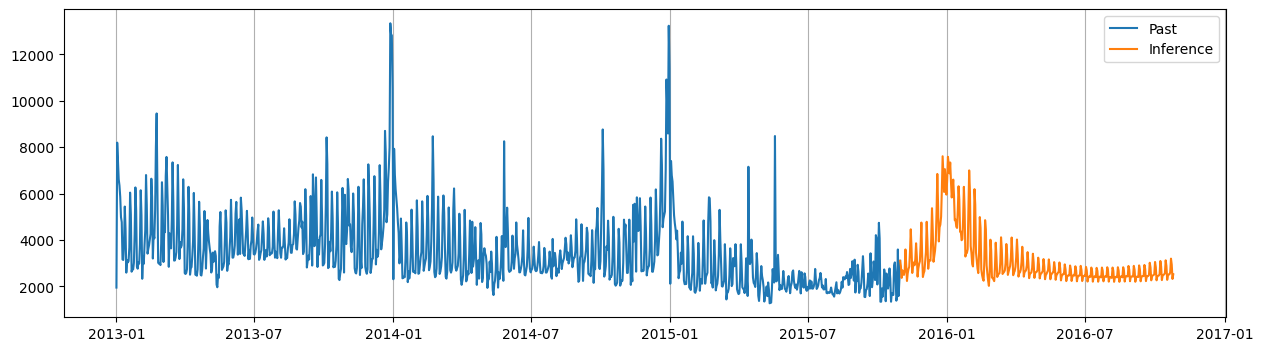

In [47]:
from module.lino_module.inference import RecurrentInference

predict_name = 'seq(7)_d_model(16)_dilation(3)_src_tgt_seq((6, 2))_weekly(True)_monthly(True)_batch_size(64)_train_rate(1.0)_'
file_path = './models_wm/' + predict_name + '.pkl'
with open(file_path, 'rb') as f:
    kw = pickle.load(f)
    
del kw['batch_size'], kw['train_rate']
ds = kw.pop('data')
freq = 360

self = RecurrentInference(**kw)
scaler = StandardScaler
self(ds, scaler)
pred = self.predict(freq)

import matplotlib.pyplot as plt
img_path = '../Lino_notebook/img_inference/'

plt.figure(figsize=(15, 4))
plt.plot(self.origin, label='Past')
plt.plot(pred, label='Inference')
plt.grid(axis='x')
plt.legend()
plt.savefig(img_path + predict_name + f'freq({freq}).png')
plt.show()

In [46]:
round(self.inferenced[1:31].sum())

119614

## Recurrent Inference Class

In [ ]:
class RecurrentInference():
    """再起的に推論を行うクラス"""
    def __init__(self,
                 model,
                 seq,
                 d_model,
                 dilation,
                 src_tgt_seq,
                 weekly=True,
                 monthly=True):
        """ Initializer
        引数:
            model: 訓練済みモデル
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
            src_tgt_seq: 訓練条件時の src_tgt_seq,
            weekly: 訓練条件時の曜日情報の有無
            monthly: 訓練条件時の月情報の有無
        """
        self.model: object = model
        self.seq: int = seq
        self.src_tgt_seq: Tuple[int] = src_tgt_seq
        self.d_model: int = d_model
        self.dilation: int = dilation
        self.weekly: bool = weekly
        self.monthly: bool = monthly

        self.origin: Optional[Series] = None
        self.df: Optional[DataFrame] = None
        self.inferenced: Optional[Series] = None
        self.embedded: ndarray = None
        self.latest_index: Timestamp = None
        self.latest_data: float = None
        self.scaler: Optional[object] = None

    def __call__(self, ds: Series, scaler: Union[StandardScaler, MinMaxScaler]):
        """入力データを登録
        引数:
            ds: 訓練データセット作成時に使用したシリーズ
            scaler: 訓練時に使用したスケーラー
        """
        self.origin = ds
        reshaped = ds.values.reshape(-1, 1)
        self.scaler = scaler().fit(reshaped)
        scaled_ds = self.scaler.transform(reshaped).reshape(-1)
        self.df = pd.DataFrame(scaled_ds,
                               columns=['data'],
                               index=ds.index.tolist())
        self.latest_index = ds.index[-1]
        self.latest_data = ds[-1]
        self.inferenced = pd.Series(self.latest_data, index=[self.latest_index])

        if self.weekly:
            self.df['weekly'] = ds.index.weekday / 6
        if self.monthly:
            self.df['monthly'] = (ds.index.month - 1) / 11

    def predict(self, freq):
        """推論用関数
        引数:
            freq: 再帰推論回数
        """
        step_num = 1  # ハードコードは後日改修
        for _ in range(freq):
            self.embedded = self.tde(self.df,
                                     self.seq,
                                     self.d_model,
                                     self.dilation)
            src, tgt = src_tgt_split(self.embedded, *self.src_tgt_seq)
            output = self.inference(self.model, src, tgt)
            scaled = output[:, -step_num]
            inversed = self.scaler.inverse_transform(scaled.reshape(-1, 1)).item()

            # 推論の追加
            self.latest_index = self.latest_index + datetime.timedelta(1)
            self.inferenced[self.latest_index] = inversed

            # datasetの更新
            latest_data = {'data': scaled.item()}
            if self.weekly:
                scaled_weekday = self.latest_index.weekday() / 6
                latest_data['weekly'] = scaled_weekday
            if self.monthly:
                scaled_month = (self.latest_index.month - 1) / 11
                latest_data['monthly'] = scaled_month
            latest = pd.DataFrame(latest_data, index=[self.latest_index])
            self.df = pd.concat((self.df, latest))
        return self.inferenced
    
    @classmethod
    def tde(self,
            df: DataFrame,
            seq: int,
            d_model: int,
            dilation: int
            ) -> ndarray:
        """Time delay Embedding
           入力データ末端のseq分からTDEデータを作成
        引数: 
            df: [data, weekly, monthly]のカラムと Timestamp インデックスを持ったデータフレーム
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
        """
        embeded = []
        for column in df.columns:
            trg = getattr(df, column)
            tded = self.tde_for_inference(trg, seq, d_model, dilation)
            embeded.append(tded.tolist())
        embeded = np.array(embeded).reshape(d_model*len(df.columns), -1)
        return embeded

    @classmethod
    def inference(self, model: object, src: Tensor, tgt: Tensor) -> ndarray:
        """推論関数
        """
        src = torch.from_numpy(src.astype(np.float32)).unsqueeze(0)
        tgt = torch.from_numpy(tgt.astype(np.float32)).unsqueeze(0)
        model.eval()
        output = model(src, tgt).detach().numpy()
        return output

    @classmethod
    def tde_for_inference(self,
                          ds: Series,
                          seq: int,
                          d_model: int,
                          dilation: int
                          ) -> ndarray:
        for_array = []
        for i in range(d_model):
            if i != 0:
                for_array.append(ds[-seq - i*(dilation + 1): -i*(dilation + 1)])
            else:
                for_array.append(ds[-seq:])
        time_delay_embedded = np.array([j for j in reversed(for_array)])
        return time_delay_embedded